In [1]:
import requests
import pandas as pd

def get_dataframe(series_code, series_name, start_period="2024-01", end_period="2025-03"):
    # BCRP API URL for a given series in JSON format with specified period range
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{series_code}/json/{start_period}/{end_period}"

    try:
        response = requests.get(url)
        if response.status_code == 403:
            return None
        response.raise_for_status()

        # Convert the JSON response content to a Pandas DataFrame
        data = response.json()
        records = data.get('periods', [])

        if not records:
            return None

        # Extract date and value pairs
        dates = [record['name'] for record in records]
        values = [float(record['values'][0]) for record in records if record['values'][0] is not None]

        # Create a DataFrame
        df = pd.DataFrame({'Date': dates[:len(values)], series_name: values})

        return df

    except requests.exceptions.RequestException as e:
        return None
    except Exception as e:
        return None

if __name__ == "__main__":
    # Example usage for different series
    series_info = [
        ("PN01247PM", "Exchange Rate (PEN to USD)"),
        ("PN01248PM", "Inflation Rate"),
        ("PN01230PM", "Interest Rate on Loans"),
        ("PN01263PM", "Foreign Exchange Reserves"),
        ("PN03475PM", "GDP Growth Rate"),
        ("PN01225PM", "Export Volume Index")
    ]

    dataframes = {}
    for code, name in series_info:
        df = get_dataframe(code, name)
        if df is not None:
            dataframes[name] = df

    # Now you can use the 'dataframes' dictionary to perform further data analysis
    # Example: Access the Exchange Rate DataFrame
    exchange_rate_df = dataframes.get('Exchange Rate (PEN to USD)')

In [2]:
exchange_rate_df.tail()

,Date,Exchange Rate (PEN to USD)
9,Oct.2024,-0.388072
10,Nov.2024,0.672931
11,Dic.2024,-1.163192
12,Ene.2025,0.344193
13,Feb.2025,-1.335468


In [3]:
# Inflation Rate DataFrame
inflation_rate_df = dataframes.get('Inflation Rate')
inflation_rate_df.tail()

,Date,Inflation Rate
9,Oct.2024,-2.362344
10,Nov.2024,0.451079
11,Dic.2024,0.032422
12,Ene.2025,0.212323
13,Feb.2025,-3.386440


In [4]:
# Foreign Exchange Reserves DataFrame
foreign_exchange_reserves_df = dataframes.get('Foreign Exchange Reserves')
foreign_exchange_reserves_df.tail()

,Date,Foreign Exchange Reserves
9,Oct.2024,63.457985
10,Nov.2024,62.175548
11,Dic.2024,58.611571
12,Ene.2025,59.895584
13,Feb.2025,62.267540


In [5]:
# prompt: Merge by Date exchange_rate_df, inflation_rate_df and foreign_exchange_reserves_df

merged_df = pd.merge(exchange_rate_df, inflation_rate_df, on='Date', how='outer')
merged_df = pd.merge(merged_df, foreign_exchange_reserves_df, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# Extract month and year from 'Date' column
merged_df['Month'] = merged_df['Date'].str.split('.').str[0]
merged_df['Year'] = merged_df['Date'].str.split('.').str[1]

# Map Spanish month names to English
month_mapping = {
    "Ene": "Jan",
    "Feb": "Feb",
    "Mar": "Mar",
    "Abr": "Apr",
    "May": "May",
    "Jun": "Jun",
    "Jul": "Jul",
    "Ago": "Aug",
    "Set": "Sep",
    "Oct": "Oct",
    "Nov": "Nov",
    "Dic": "Dec"
}

merged_df['Month'] = merged_df['Month'].replace(month_mapping)

# Concatenate 'Month' and 'Year' to form a new 'Date' column
merged_df['Date'] = pd.to_datetime(merged_df['Month'] + ' ' + merged_df['Year'], format="%b %Y", errors='coerce')

# Drop 'Month' and 'Year' columns as they are no longer needed
merged_df = merged_df.drop(columns=['Month', 'Year'])
merged_df = merged_df.sort_values('Date', ascending=False)
merged_df.head()

,Date,Exchange Rate (PEN to USD),Inflation Rate,Foreign Exchange Reserves
6,2025-02-01,-1.335468,-3.386440,62.267540
4,2025-01-01,0.344193,0.212323,59.895584
2,2024-12-01,-1.163192,0.032422,58.611571
11,2024-11-01,0.672931,0.451079,62.175548
12,2024-10-01,-0.388072,-2.362344,63.457985


Daily Exchange Rate

In [6]:
import requests
import pandas as pd

def get_daily_exchange_rate(series_code="PD04640PD", start_date="2013-01-01", end_date=pd.Timestamp.today().strftime('%Y-%m-%d')):
    # BCRP API URL for daily exchange rate data in JSON format with specified date range
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{series_code}/json/{start_date}/{end_date}"

    response = requests.get(url)
    response.raise_for_status()

    # Convert the JSON response content to a Pandas DataFrame
    data = response.json()
    records = data.get('periods', [])

    if not records:
        return pd.DataFrame(columns=['Date', 'Exchange Rate (PEN to USD)'])

    # Extract date and value pairs, handle 'n.d.' values gracefully
    dates = [record['name'] for record in records]
    values = [float(record['values'][0]) if record['values'] and record['values'][0] != 'n.d.' else None for record in records]

    # Create a DataFrame
    df = pd.DataFrame({'Date': dates, 'Exchange Rate (PEN to USD)': values})

    # Parse the date using a more flexible approach
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

    # Drop rows with missing exchange rate values or invalid dates
    df = df.dropna(subset=['Exchange Rate (PEN to USD)', 'Date'])

    return df

In [7]:
# Example usage to get a DataFrame
daily_exchange_rate_df = get_daily_exchange_rate()
daily_exchange_rate_df.tail()

C:\Users\patri\AppData\Local\Temp\ipykernel_19188\513906109.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


,Date,Exchange Rate (PEN to USD)
3174,2025-03-04,3.693
3175,2025-03-05,3.663
3176,2025-03-06,3.651
3177,2025-03-07,3.659
3178,2025-03-10,3.669


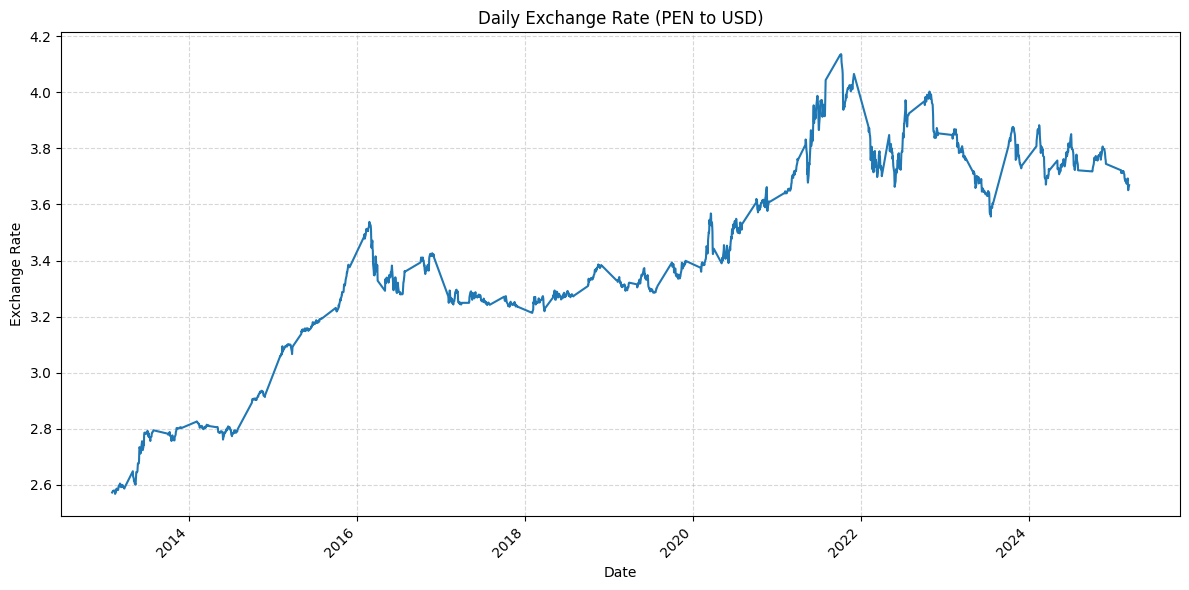

In [8]:
# prompt: generate a lineplot using seaborn of the daily_exchange_rate_df dataframe using the date as X axis and Exchange rate as Y axis. make it look clean and orgnize and less white noise in the visualization so choose your seaborn params very wisely

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming daily_exchange_rate_df is your DataFrame
# and it has 'Date' and 'Exchange Rate (PEN to USD)' columns

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='Date', y='Exchange Rate (PEN to USD)', data=daily_exchange_rate_df, linewidth=1.5)

# Customize the plot for better readability
plt.title('Daily Exchange Rate (PEN to USD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True, linestyle='--', alpha=0.5)  # Add a grid for better visualization

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

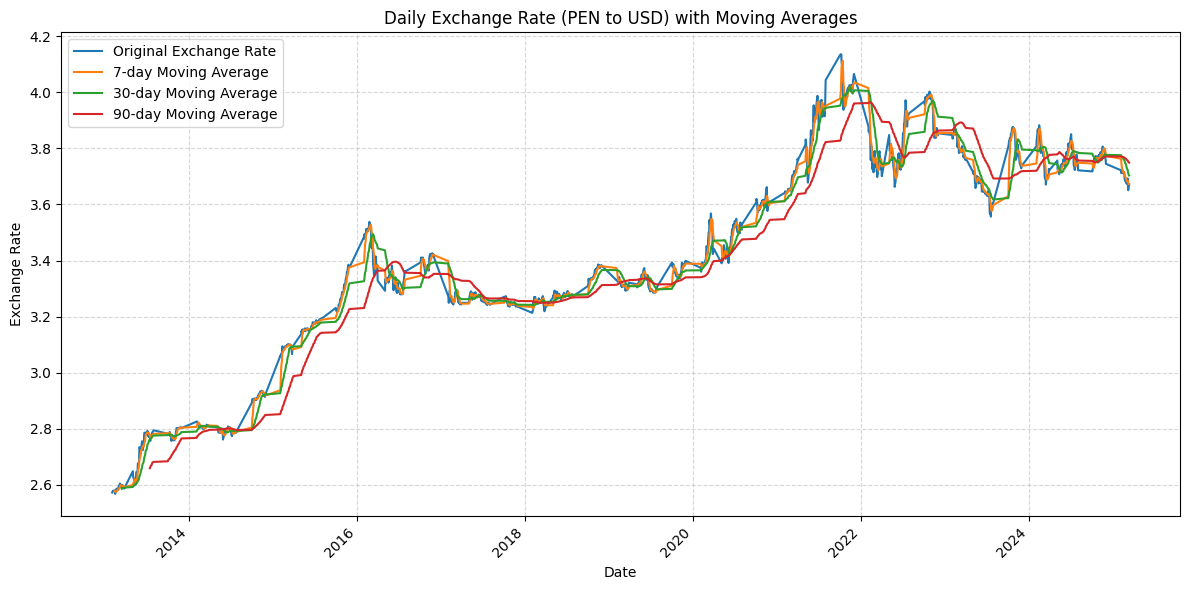

In [9]:
# Assuming daily_exchange_rate_df is your DataFrame
# and it has 'Date' and 'Exchange Rate (PEN to USD)' columns

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='Date', y='Exchange Rate (PEN to USD)', data=daily_exchange_rate_df, linewidth=1.5, label='Original Exchange Rate')

# Calculate and plot different moving averages
window_sizes = [7, 30, 90]  # 7-day, 30-day, and 90-day moving averages
for window_size in window_sizes:
  daily_exchange_rate_df[f'{window_size}-day MA'] = daily_exchange_rate_df['Exchange Rate (PEN to USD)'].rolling(window=window_size).mean()
  sns.lineplot(x='Date', y=f'{window_size}-day MA', data=daily_exchange_rate_df, label=f'{window_size}-day Moving Average')


# Customize the plot for better readability
plt.title('Daily Exchange Rate (PEN to USD) with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True, linestyle='--', alpha=0.5)  # Add a grid for better visualization

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

### Daily inflation rate

In [10]:
import requests
import pandas as pd

# Function to get the daily inflation rate
def get_daily_inflation_rate(series_code="PN01248PM", start_date="2013-01-01", end_date=pd.Timestamp.today().strftime('%Y-%m-%d')):
    # BCRP API URL for daily inflation rate data in JSON format with specified date range
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{series_code}/json/{start_date}/{end_date}"

    response = requests.get(url)
    response.raise_for_status()

    # Convert the JSON response content to a Pandas DataFrame
    data = response.json()
    records = data.get('periods', [])

    if not records:
        return pd.DataFrame(columns=['Date', 'Inflation Rate'])

    # Extract date and value pairs, handle 'n.d.' values gracefully
    dates = [record['name'] for record in records]
    values = [float(record['values'][0]) if record['values'] and record['values'][0] != 'n.d.' else None for record in records]

    # Create a DataFrame
    df = pd.DataFrame({'Date': dates, 'Inflation Rate': values})

    # Parse the date using a more flexible approach
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

    # Drop rows with missing inflation rate values or invalid dates
    df = df.dropna(subset=['Inflation Rate', 'Date'])

    return df

In [11]:
# Example usage to get inflation rate data
daily_inflation_rate_df = get_daily_inflation_rate()
daily_inflation_rate_df.tail()

C:\Users\patri\AppData\Local\Temp\ipykernel_19188\112696763.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


,Date,Inflation Rate
138,2024-07-01,4.528920
140,2024-09-01,1.033541
141,2024-10-01,-2.362344
142,2024-11-01,0.451079
145,2025-02-01,-3.386440


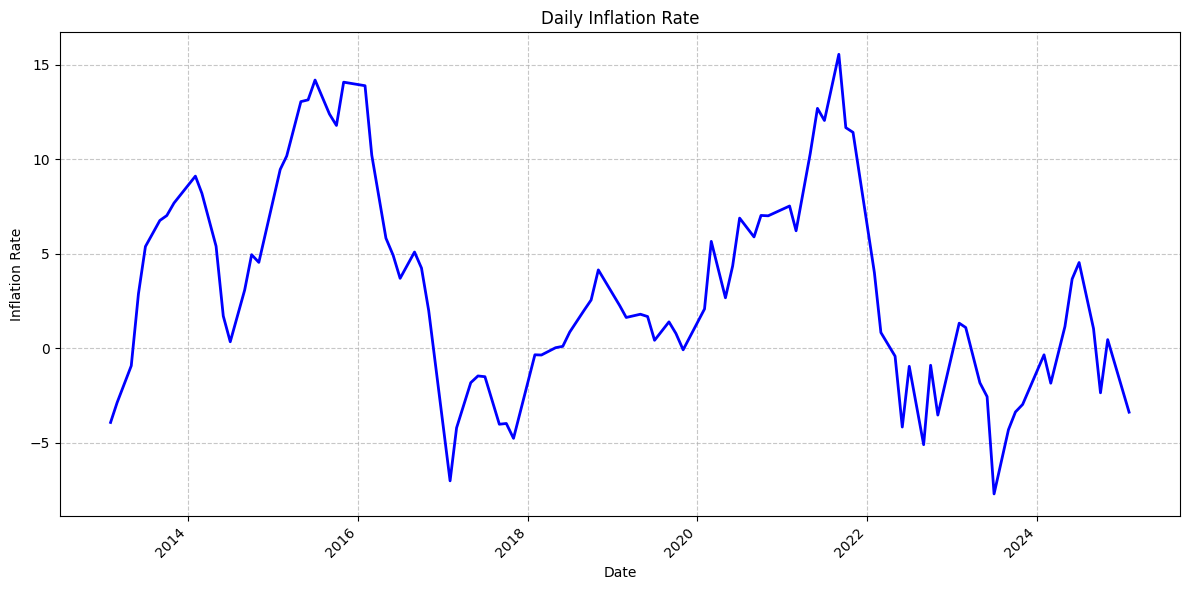

In [12]:
# Assuming daily_inflation_rate_df is your DataFrame
# and it has 'Date' and 'Inflation Rate' columns

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='Date', y='Inflation Rate', data=daily_inflation_rate_df, linewidth=2, color='blue')

# Customize the plot for better readability
plt.title('Daily Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better visualization

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

GDP Growth Rate by Central Bank


In [13]:
# Function to get yearly GDP growth rate from the World Bank API
def get_world_bank_gdp_growth(country_code="PE", indicator_code="NY.GDP.MKTP.KD.ZG", start_year="2000", end_year="2024"):
    # World Bank API URL for yearly GDP growth rate data
    url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}?date={start_year}:{end_year}&format=json"

    response = requests.get(url)
    response.raise_for_status()

    # Convert the JSON response content to a Pandas DataFrame
    data = response.json()
    if len(data) < 2:
        return pd.DataFrame(columns=['Year', 'GDP Growth Rate'])
    records = data[1]

    # Extract year and value pairs, handle None values gracefully
    years = [str(record['date']) for record in records]
    values = [record['value'] if record['value'] is not None else None for record in records]

    # Create a DataFrame
    df = pd.DataFrame({'Year': years, 'GDP Growth Rate': values})

    # Drop rows with missing GDP growth rate values
    df = df.dropna(subset=['GDP Growth Rate'])

    return df

In [14]:
# Example usage to get GDP growth rate data
yearly_gdp_growth_df = get_world_bank_gdp_growth()
yearly_gdp_growth_df.head()

,Year,GDP Growth Rate
0,2023,-0.550182
1,2022,2.725500
2,2021,13.355230
3,2020,-10.933307
4,2019,2.240632


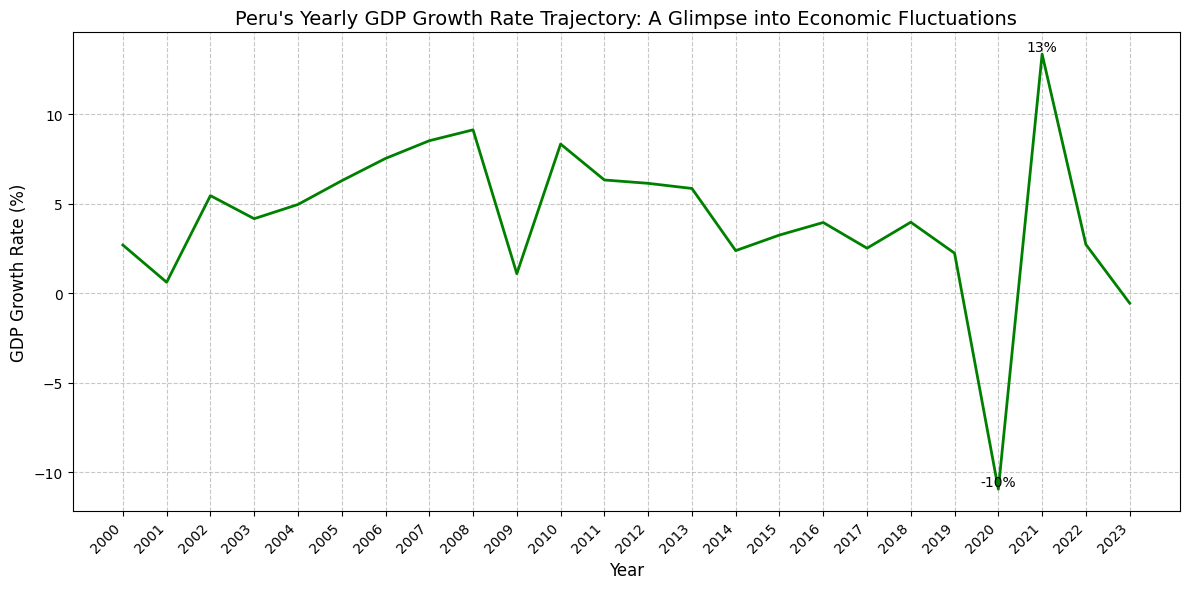

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by Year in ascending order
yearly_gdp_growth_df = yearly_gdp_growth_df.sort_values('Year')

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
ax = sns.lineplot(x='Year', y='GDP Growth Rate', data=yearly_gdp_growth_df, linewidth=2, color='green')

# Customize the plot for better readability
plt.title('Peru\'s Yearly GDP Growth Rate Trajectory: A Glimpse into Economic Fluctuations', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better visualization

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45, ha='right')

# Find the minimum and maximum values
min_value_row = yearly_gdp_growth_df.loc[yearly_gdp_growth_df['GDP Growth Rate'].idxmin()]
max_value_row = yearly_gdp_growth_df.loc[yearly_gdp_growth_df['GDP Growth Rate'].idxmax()]

# Add data labels to the lowest and highest values
ax.text(min_value_row['Year'], min_value_row['GDP Growth Rate'],
        f"{int(min_value_row['GDP Growth Rate'])}%", ha='center', va='bottom')

ax.text(max_value_row['Year'], max_value_row['GDP Growth Rate'],
        f"{int(max_value_row['GDP Growth Rate'])}%", ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
import os
from dotenv import load_dotenv
from openai import OpenAI
# Cargar variables de entorno desde el archivo .env
load_dotenv()
class EconomicChatbot:
   def __init__(self, exchange_rates_df, inflation_rates_df, gdp_df):
       # La API key se obtiene de las variables de entorno
       self.client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
       self.conversation_history = []
       
       # Almacenar los dataframes como contexto
       self.exchange_rates = daily_exchange_rate_df
       self.inflation_rates = daily_inflation_rate_df
       self.gdp = yearly_gdp_growth_df
   
   def get_context_prompt(self):
       # Crear un prompt con el contexto económico actual
       context = f"""
       Contexto económico actual de Perú:
       
       Tipo de cambio diario (PEN/USD): {self.exchange_rates.iloc[-1]['Exchange Rate (PEN to USD)']:.3f}
       Inflación más reciente: {self.inflation_rates.iloc[-1]['Inflation Rate']:.2f}%
       Crecimiento del PIB 2000-2023: {self.gdp.iloc[0]['GDP Growth Rate']:.2f}%
       
       Tendencias:
       - Tipo de cambio: {', '.join(f"{x:.3f}" for x in self.exchange_rates['Exchange Rate (PEN to USD)'].tolist())}
       - Inflación en términos de variación porcentual: {', '.join(f"{x:.2f}%" for x in self.inflation_rates['Inflation Rate'].tolist())}
       - PIB 2000-2023: {', '.join(f"{x:.2f}%" for x in self.gdp['GDP Growth Rate'].tolist())}
       """
       return context
   
   def get_streaming_response(self, prompt):
       try:
           # Construir el prompt completo con contexto e historial
           full_prompt = self.get_context_prompt() + "\n\nHistorial de conversación:\n"
           
           for msg in self.conversation_history:
               if msg["role"] == "user":
                   full_prompt += f"""
                   Human: {msg['content']}
                   """
               else:
                   full_prompt += f"""
                   Assistant: {msg['content']}
                   """
           
           full_prompt += f"""
           Human: {prompt}
           Assistant:"""
           
           # Realizar la llamada a la API con streaming
           response = self.client.chat.completions.create(
               model="gpt-4o",
               messages=[{
                   "role": "user", 
                   "content": full_prompt.strip()
               }],
               stream=True
           )
           
           # Procesar la respuesta streaming
           for chunk in response:
               if chunk.choices[0].delta.content is not None:
                   yield chunk.choices[0].delta.content
                   
       except Exception as e:
           yield f"""
           Error: {str(e)}
           """
   
   def update_history(self, prompt, response):
       self.conversation_history.extend([
           {"role": "user", "content": prompt},
           {"role": "assistant", "content": response}
       ])

# Crear instancia del chatbot con los datos económicos
economic_bot = EconomicChatbot(
   exchange_rates_df=daily_exchange_rate_df,
   inflation_rates_df=daily_inflation_rate_df,
   gdp_df=yearly_gdp_growth_df)

In [17]:
response = economic_bot.get_streaming_response("Realiza un reporte con 3 secciones acerca de la comparación del año 2023 vs el año anterior de la economia peruana. El reporte tiene que estar respaldado por la mayor cantidad de metricas y datos posibles")
for chunk in response:
    print(chunk, end='')

**Reporte Comparativo del Año 2023 vs Año Anterior de la Economía Peruana**

---

**I. Comparación del Tipo de Cambio**

- **Actualidad del Tipo de Cambio:**
  - En 2023, el tipo de cambio se encuentra en 3.669 PEN/USD. Esto representa un aumento respecto al año anterior. Analizando las tendencias previas, se observa que el tipo de cambio ha mantenido una tendencia creciente desde valores de 3.532 a finales del año anterior.

- **Tendencias Observadas:**
  - A lo largo del año, el tipo de cambio escaló con picos significativos en algunos momentos, alcanzando máximos alrededor de 3.987. Estos cambios pueden estar influenciados por factores globales, incertidumbre política interna y dinámica de importación/exportación.
  - La depreciación del sol frente al dólar puede tener implicancias en la balanza comercial, la deuda externa y las expectativas inflacionarias.

**II. Estudio de la Inflación**

- **Inflación en 2023:**
  - La inflación más reciente en 2023 indica una caída del -3.39%. E